<a href="https://colab.research.google.com/github/Dyinastie/Machine_Learning/blob/main/ML_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **MODEL**

In [ ]:
!pip install keras-facenet
from keras_facenet import FaceNet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=493f9d70405c163e2a4b01a9d7fb29af60c44dd31ec03bf590f793efed73abdf
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
# Load Model FaceNet
MyFaceNet = FaceNet()

# **TAKE PHOTO**

In [ ]:
import cv2
import numpy as np
import PIL.Image
import io
from base64 import b64decode, b64encode
from google.colab import output, drive
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Fungsi untuk mengonversi string base64 dari JavaScript menjadi gambar OpenCV (BGR)
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Fungsi untuk mengonversi array gambar (dengan kotak batas) menjadi string base64 PNG untuk ditampilkan di browser
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Inisialisasi cascade classifier untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# Fungsi untuk mengambil gambar
def take_photo(directory='/content/drive/MyDrive/Semester 5/PBL/Images/Train', filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality){
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Mengambil data gambar dari kamera
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Konversi gambar menjadi grayscale untuk deteksi wajah
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(f"Grayscale image shape: {gray.shape}")

    # Deteksi wajah
    faces = face_cascade.detectMultiScale(gray)
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Validasi ekstensi file dan simpan gambar
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        raise ValueError("Nama file harus memiliki ekstensi .jpg, .jpeg, atau .png")

    save_path = f"{directory}/{filename}"
    cv2.imwrite(save_path, img)

    return save_path

Mounted at /content/drive


Masukkan nama file (contoh: wajah1.jpg): Zachrida.jpg


<IPython.core.display.Javascript object>

Grayscale image shape: (480, 640)
Gambar berhasil disimpan di: /content/drive/MyDrive/Semester 5/PBL/Images/Train/Zachrida.jpg


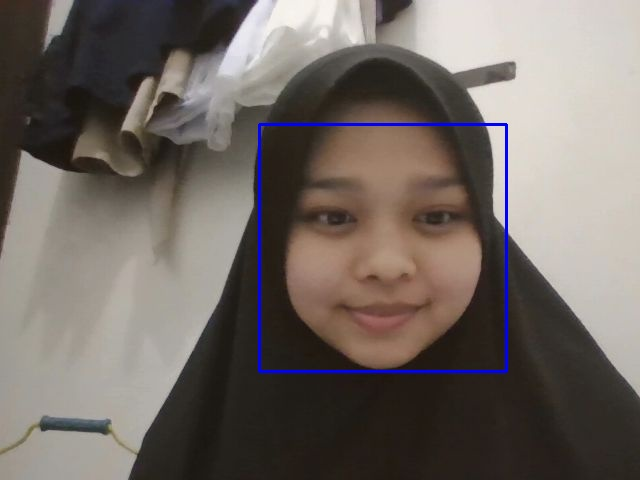

In [ ]:
try:
    # Meminta nama file dari pengguna
    custom_filename = input("Masukkan nama file (contoh: wajah1.jpg): ")
    if not custom_filename:
        custom_filename = 'photo.jpg'  # Nama default jika input kosong

    filepath = take_photo(filename=custom_filename)
    print(f'Gambar berhasil disimpan di: {filepath}')

    # Menampilkan gambar yang telah disimpan
    display(Image(filepath))
except Exception as err:
    print(f"Terjadi kesalahan: {err}")

# **USE MODEL**

In [ ]:
import cv2
import numpy as np
import os
from keras_facenet import FaceNet
import matplotlib.pyplot as plt

# Path ke folder gambar
image_folder_path = '/content/drive/MyDrive/Semester 5/PBL/Images/Train'

# Fungsi untuk mendeteksi wajah dan mengekstrak embedding
def detect_face_and_get_embedding(image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Gambar tidak ditemukan di path {image_path}")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Inisialisasi detektor wajah OpenCV
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
    faces = face_classifier.detectMultiScale(img_rgb, scaleFactor=1.1, minNeighbors=5)

    embeddings = []
    for (x, y, w, h) in faces:
        # Ekstrak wajah dari gambar
        face = img_rgb[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (160, 160))

        # Tambahkan dimensi batch ke input (1, 160, 160, 3)
        face_resized = np.expand_dims(face_resized, axis=0)

        # Ekstrak embedding menggunakan model FaceNet
        embedding = MyFaceNet.embeddings(face_resized)
        embeddings.append((embedding, (x, y, w, h)))

    return img_rgb, embeddings

# Fungsi untuk menampilkan gambar dan wajah yang terdeteksi dengan nama hasil prediksi
def display_faces_with_prediction(image, embeddings, known_faces):
    for embedding, (x, y, w, h) in embeddings:
        # Bandingkan embedding wajah dengan wajah yang dikenal
        match_name, similarity = recognize_face(known_faces, embedding)

        # Gambar kotak pada wajah yang terdeteksi
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Tampilkan nama hasil prediksi di atas kotak wajah tanpa ekstensi
        if similarity is not None:
            label = f"{match_name} ({similarity:.2f})"
        else:
            label = f"{match_name}"  # Jika similarity None, hanya tampilkan nama

        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Fungsi untuk mengenali wajah dengan mencocokkan embedding
def recognize_face(known_faces, test_embedding, similarity_threshold=0.5):
    best_match_name = None
    best_similarity = float('inf')  # Similarity terendah berarti cocok

    # Bandingkan embedding wajah yang terdeteksi dengan yang dikenal
    for name, (embedding, file_name) in known_faces.items():
        similarity = np.linalg.norm(test_embedding - embedding)  # Menggunakan Euclidean distance
        if similarity < best_similarity:
            best_similarity = similarity
            # Menghilangkan ekstensi dari nama file
            best_match_name = os.path.splitext(file_name)[0]  # Menggunakan nama file tanpa ekstensi

    # Menyembunyikan nilai similarity jika terlalu kecil (misalnya di bawah threshold)
    if best_similarity < similarity_threshold:
        return best_match_name, None  # Tidak tampilkan similarity jika di bawah threshold
    else:
        return best_match_name, best_similarity

# Inisialisasi model FaceNet
MyFaceNet = FaceNet()

# Fungsi untuk membuat known_faces dengan nama file
def load_known_faces(image_folder_path):
    known_faces = {}

    for filename in os.listdir(image_folder_path):
        if filename.endswith(".jpg"):  # Ganti sesuai dengan ekstensi gambar yang Anda gunakan
            image_path = os.path.join(image_folder_path, filename)
            img, embeddings = detect_face_and_get_embedding(image_path)
            if embeddings:
                known_faces[filename] = (embeddings[0][0], filename)  # Menyimpan embedding dan nama file

    return known_faces

# Muat dataset wajah yang dikenal
known_faces = load_known_faces(image_folder_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


# **FACE RECOGNITION**

In [ ]:
# Fungsi untuk mengambil gambar baru dan menguji
def take_and_test_photo():
    # Nama file gambar uji
    test_filename = "test.jpg"
    test_image_path = f"/content/drive/MyDrive/Semester 5/PBL/Images/Test/{test_filename}"

    # Ambil gambar dan simpan
    take_photo(directory='/content/drive/MyDrive/Semester 5/PBL/Images/Test', filename=test_filename)

    # Deteksi wajah dan ekstrak embedding untuk gambar uji
    test_img, test_embeddings = detect_face_and_get_embedding(test_image_path)

    if test_embeddings:
        # Ambil embedding pertama (jika ada beberapa wajah, hanya gunakan satu)
        test_embedding = test_embeddings[0][0]

        # Cari wajah yang paling cocok
        match_name, similarity = recognize_face(known_faces, test_embedding)

        # Tampilkan hasil
        if match_name:
            if similarity is not None:
                print(f"Wajah cocok ditemukan: {match_name} (Similarity: {similarity:.2f})")
            else:
                print(f"Wajah cocok ditemukan: {match_name}")

            train_image_path = os.path.join(image_folder_path, match_name + ".jpg")

            # Menampilkan gambar uji dan gambar asli (train) yang cocok
            train_img = cv2.imread(train_image_path)
            train_img_rgb = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Gambar Uji")
            plt.imshow(test_img)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Gambar Train (Cocok)")
            plt.imshow(train_img_rgb)
            plt.axis('off')
            plt.show()
        else:
            print("Tidak ada wajah yang cocok ditemukan.")
    else:
        print("Tidak ada wajah terdeteksi pada gambar uji.")

Memuat dataset wajah dikenal...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


<IPython.core.display.Javascript object>

Grayscale image shape: (480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Wajah cocok ditemukan: Zachrida


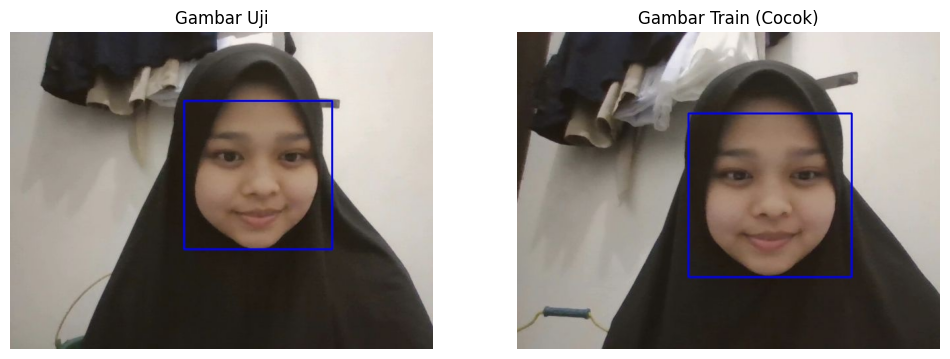

In [ ]:
# Uji fungsi
try:
    # Muat dataset wajah dikenal terlebih dahulu
    print("Memuat dataset wajah dikenal...")
    known_faces = load_known_faces(image_folder_path)

    # Ambil gambar baru dan lakukan uji pencocokan
    take_and_test_photo()
except Exception as e:
    print(f"Terjadi kesalahan: {e}")